In [144]:
### Install required libraries
!pip install -U tensorflow==2.3.2
!pip install --quiet /kaggle/input/kerasapplications #additional models
!pip install --quiet /kaggle/input/efficientnet-git #efficientnet model for keras

Requirement already up-to-date: tensorflow==2.3.2 in /opt/conda/lib/python3.7/site-packages (2.3.2)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [145]:
###Get required libraries for TPU
!pip install cloud-tpu-client
import tensorflow as tf 
from cloud_tpu_client import Client
Client().configure_tpu_version(tf.__version__, restart_type='ifNeeded')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [146]:
###More imports

import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
from kaggle_datasets import KaggleDatasets

import os
import cv2
import re
import math
import datetime
import time
from collections import namedtuple

from functools import partial

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense, Dropout,\
        Flatten,GlobalAveragePooling2D,BatchNormalization, Activation

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [147]:
main_dir = '../input/cassava-leaf-disease-classification/' #Set our data directory 
os.listdir(main_dir) #List files in our directory
train_img_path = '../input/cassava-leaf-disease-classification/train_images' #point to training images

In [148]:
###Set up kaggle TPU's

###Try to connect to our TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() #Set up our TPU
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

###Configure the notebook to use the TPU or lackthereof 
if tpu:
    tf.config.experimental_connect_to_cluster(tpu) 
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

REPLICAS = strategy.num_replicas_in_sync #Check how many simultaneous processes our TPU can handle
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


In [149]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #keras optimization of value 

GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification') #Set google cloud storage data path for our default dataset
GCS_NewTFPure512 = KaggleDatasets().get_gcs_path('cassava-leaf-disease-tfrecords-512x512')# using a cleaned dataset posted by another member on kaggle        


###Data paramaters
IMAGE_SIZE = [512,512]
CLASSES = ['0', '1', '2', '3', '4']

###Model runtime paramaters, number of folds and early stopping
N_FOLDS = 5
PATIENCE = 15 
PATIENT = 10

SEED = 100
MODEL_NAME = "EfficentNetB3"

###More image paramaters
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5

###BiTemperedLoss function paramaters
T_1 = 0.6
T_2 = 1.4
SMOOTH_FRACTION = 0.1
N_ITER = 5

#Model variables
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 30
input_shape = (512,512,3)
dropout_rate = 0.2

MODEL_SAVE_PATH = ""

In [150]:
dataframe = pd.read_csv(main_dir+'train.csv') #Load our directory into a pd dataframe

imgs_id = dataframe['image_id'].values#Store image ids and labels
imgs_label = dataframe['label'].values
print('Head of the CSV file \n\n',dataframe.head())
print('\n Lenght of the image label : ',len(dataframe['label']))
print('\n length of the image id :', len(dataframe['image_id']))

Head of the CSV file 

          image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

 Lenght of the image label :  21397

 length of the image id : 21397


In [151]:
DATASET_FILENAMES = tf.io.gfile.glob(GCS_NewTFPure512 + '/Id_train*.tfrec')#Store our training dataset filenames in a list

NUM_FILES = len(DATASET_FILENAMES)
np.random.shuffle(DATASET_FILENAMES)#Shuffle the training data to allow for a better distrubition
display(DATASET_FILENAMES)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test00-1.tfrec')#Only 1 test file given to us

['gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train04-1427.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train08-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train12-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train13-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train06-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train07-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train10-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train02-1427.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train14-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train05-1426.tfrec',
 'gs://kds-8b25f1242ebf8f91e8a1586f4f6a2751c4cf20c6c29316583a4dcf36/Id_train03-1

In [152]:
import plotly_express as px

labelCounts = dataframe['label'].value_counts().reset_index()
labelCounts.columns = ['Label', 'Number of Observations']

# Plotting a Pie Chart to show the Distribution
fig = px.pie(labelCounts, 
             names = 'Label',values='Number of Observations', 
             labels = CLASSES, 
             title = 'Distribution of Labels in the Training Dataset',
             color_discrete_sequence=px.colors.sequential.Greens_r)
fig.show()

# Functions - data augmention

In [153]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [154]:
### Data augmentation function, can be used in the place of functions in the cell above, this one applies random transformations
###to our data

def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
#     # Shear
#     if p_shear > .2:
#         if p_shear > .6:
#             image = transform_shear(image, HEIGHT, shear=20.)
#         else:
#             image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     if p_spatial > .75:
#         image = tf.image.transpose(image)
        
#     # Rotates
#     if p_rotate > .75:
#         image = tf.image.rot90(image, k=3) # rotate 270º
#     elif p_rotate > .5:
#         image = tf.image.rot90(image, k=2) # rotate 180º
#     elif p_rotate > .25:
#         image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
#     # Crops
#     if p_crop > .6:
#         if p_crop > .9:
#             image = tf.image.central_crop(image, central_fraction=.5)
#         elif p_crop > .8:
#             image = tf.image.central_crop(image, central_fraction=.6)
#         elif p_crop > .7:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.8)
#     elif p_crop > .3:
#         crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

# Functions - loading and preparing the datasets

In [155]:
 ###One hot encoding of the data https://en.wikipedia.org/wiki/One-hot

def one_hot(image, label):
    label = tf.one_hot(label, len(CLASSES), dtype = tf.float32)
    return image,label

In [156]:
#Decode the data
#turn the images into tensors
#normalize the image (get every pixel to have a value between 0 and 1)
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [157]:
#setting up variables X and y; in this case image and prediction (for images with no label)
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [158]:
# the following code will load the dataset using the TPU
#IF load dataset is used comment out the other code block below
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [159]:
#The following functions will be used to load our training, validation, and test datasets, as well as print out the number of images in each dataset.
#If this codeblock is used commment out above codeblock
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE)  #Map our one hot encoded dataset using keras optimizer
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  #Map our augmeneted dataset
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)#Shuffle the dataset
    dataset = dataset.batch(BATCH_SIZE)#Set the batch size of our data
    dataset = dataset.prefetch(AUTOTUNE)#Allow later parts of the dataset to be processed while the current element is being processed
    return dataset


def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)



# NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
# NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
# NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)


# print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
#     NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Loss function


In [160]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/bitempered-logistic-loss-tensorflow-v2/bi_tempered_loss.py", dst = "../working/loss.py")

# import all our functions
from loss import bi_tempered_logistic_loss

In [161]:
class BiTemperedLogisticLoss(tf.keras.losses.Loss):
  def __init__(self, t1, t2, lbl_smth, n_iter):
    super(BiTemperedLogisticLoss, self).__init__() #add our class to the keras classes, allowing us to call on it
    self.t1 = t1
    self.t2 = t2
    self.lbl_smth = lbl_smth
    self.n_iter = n_iter

  def call(self, y_true, y_pred):#method to return our loss function
    return bi_tempered_logistic_loss(y_pred, y_true, self.t1, self.t2, self.lbl_smth, self.n_iter)

# Model

In [162]:
import efficientnet.keras as efn

with strategy.scope():
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):#Cyclical learning rrate
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)#Modify the learning rate at each epoch
    ###Our model function    
    def get_model():
        #Set our base model, using weights from an online database
        conv_base = efn.EfficientNetB3(weights='noisy-student', include_top = False, input_shape = input_shape)
        conv_base.trainable = True#Set our base model to be trainable, which allows it to update its weights
    
        model = models.Sequential()#Create our sequential model and add extra layers to our base model
        model.add(conv_base)
        model.add(layers.GlobalAveragePooling2D(name="gap"))#Add pooling to our model, downscaling our image as it passes through this layer
        model.add(layers.Dense(16, activation="relu", name="intermediate"))#Add an additonal dense layer to our model
        model.add(layers.Dropout(dropout_rate, name="dropout_out"))#Add dropout to our model, turning off neurons increasing training efficiency, 0.5 was chosen as it is the most random
        model.add(layers.Dense(5, activation="softmax", name="fc_out"))#Final dense layer with neurons for each label
        
        optimizer = tf.keras.optimizers.Adam()#optimizer for compiling the model
        
        #Set our bitempered loss function parameters
        T_1 = 0.6
        T_2 = 1.4
        SMOOTH_FRACTION = 0.1
        N_ITER = 5
        
        model.compile(optimizer=optimizer, 
                      loss=BiTemperedLogisticLoss(t1=T_1, t2=T_2, lbl_smth=SMOOTH_FRACTION, n_iter=N_ITER), 
                      metrics=['categorical_accuracy'])#Compile the model using our specified paramaters and loss function
        
        return model

# Learning rate

Learning rate schedule: 1e-05 to 1e-05 to 1e-05


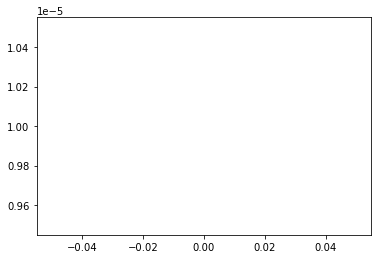

In [163]:
###Cyclical learning rate paramaters
LR_START = 0.00001#Starting learning rate
LR_MAX = 0.00005 * strategy.num_replicas_in_sync#Max learning rate, based on number of TPU cores
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5 #When to increase LR 
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8 # LR decay, mimicking a typical LR function
        
###Function to decide how to change the larning rate, should be done using a triangular cyclical learning rate
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) 
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [164]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
def get_checkpoint(model_save_path):
    return ModelCheckpoint(model_save_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'min', 
                             save_weights_only = False)

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
def get_early_stopping():
    return EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = PATIENCE, mode = 'min', verbose = 1,
                           restore_best_weights = True)
    
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
def get_learning_rate_decay():
  return ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                              patience = 1, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

###Model callback function to allow us to tune paramaters while training is happening, such as LR
def get_model_callback( fold_num):
    model_save_path_last = f'{MODEL_NAME}_last_fold_{fold_num}_.h5'
    print("Last model save path: ", model_save_path_last)
    
#saves the most recent model
    checkpoint_last = get_checkpoint(model_save_path_last)

    early_stopping = get_early_stopping()
#     learning_rate_decay = get_learning_rate_decay()

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

    return [checkpoint_last, early_stopping, lr_callback]

# Training 

In [165]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)#Set up our kfold crossvalidation

for fold , (X_train, X_valid) in enumerate(skf.split(np.arange(NUM_FILES))):

    print("Start Fold: ",fold);

    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    TRAINING_FILENAMES = [DATASET_FILENAMES[x] for x in X_train] #Assign training data per fold that was split in the for loop
    VALID_FILENAMES = [DATASET_FILENAMES[x] for x in X_valid]
        
    ct_train = count_data_items(TRAINING_FILENAMES)#Count our training data
    ct_valid = count_data_items(VALID_FILENAMES)

    print("Train File: ",ct_train)
    print("Valid File: ", ct_valid)

    STEPS_PER_EPOCH =  ct_train// BATCH_SIZE 
    VALIDATION_STEPS = ct_valid // BATCH_SIZE
    
    callback_list = get_model_callback(fold) #Save our previous models

    tf.keras.backend.clear_session()#Clear our previous model paramaters
        
    with strategy.scope():# Fit the model
        model = get_model()
        history = model.fit( x=get_training_dataset(),#Get  data after each loop, since each paramater will change
                                steps_per_epoch = STEPS_PER_EPOCH,
                                epochs = EPOCHS,
                                validation_data = get_validation_dataset(), 
                                validation_steps = VALIDATION_STEPS,
                                callbacks = callback_list)

Start Fold:  0
Train File:  17116
Valid File:  4279
Last model save path:  EfficentNetB3_last_fold_0_.h5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
133/133 [==============================] - ETA: 0s - loss: 0.6178 - categorical_accuracy: 0.4865
Epoch 00001: saving model to EfficentNetB3_last_fold_0_.h5
133/133 [==============================] - 93s 700ms/step - loss: 0.6178 - categorical_accuracy: 0.4865 - val_loss: 0.6219 - val_categorical_accuracy: 0.6063
Start Fold:  1
Train File:  17115
Valid File:  4280
Last model save path:  EfficentNetB3_last_fold_1_.h5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
133/133 [==============================] - ETA: 0s - loss: 0.6084 - categorical_accuracy: 0.5507
Epoch 00001: saving model to EfficentNetB3_last_fold_1_.h5
133/133 [==============================] - 78s 589ms/step - loss: 0.6084 - categorical_accuracy: 0.5507 - val_loss: 0.6244 - val_categorical_accuracy: 0.5215
Start Fold:  2
Train Fil